# Weekly Sales Forecast

This notebook covers our approach on predicting the total sales of `ClientCo` in the next 9 weeks period (22 September 2019 - 22 November 2019). 
* We are using weekly sales to avoid daily fluctuation with the weekend sales being negligible.
* We are building a Time Series Forecast on two levels: 
  1. Forecast of total sales of `ClientCo`
  2. Forecast of the 6 different customer segments we have developed using RFM. 
* For the forecast we are using `Facebook Prophet`, the open source software released by Facebook's core Data Science Team. We chose this model due to the following reasons:
  1. It performs well with time series that have strong seasonal effects and several seasons of historical data. 
  2. It is also robust to missing data and shifts in the trend
  3. It can handle outliers.
 
* For evaluating our forecast we are using `MAPE` and `MAE` score, which are popular metrics when evaluating forecasting models.

## **Content**
1. [Data Collection](#0)
2. [Data Preprocessing](#1)     
3. [Forecasting Model](#2)   
  3.1. [Total Sales Prediction](#3)   
  3.2. [Segment Level Sales Prediction](#4)   

<a id='0'></a>
## 1. Data Collection

In [ ]:
# First we import all the required libraries
import numpy as np
import pandas as pd
import datetime as dt
import time
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from matplotlib.pyplot import figure
import warnings
import datetime
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.3f}'.format

We have installed the libraries required for forecasting (pystan, prophet) in Google Drive, to not have to install them everytime we run the code. Here we are importing them straight from google drive:

In [ ]:
from google.colab import drive 
#drive is a module that allows us use Python to interact with google drive
drive.mount('/content/gdrive') 

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')
import pystan
import prophet

Mounted at /content/gdrive


In [ ]:
# Time to load the datasets of daily sales and daily sales by customer segment
df0=pd.read_csv('Daily Sales.csv')
df1=pd.read_csv('Daily Sales by Segment.csv')

In [ ]:
df0.head()

,date_order,total_sales
0,2018-03-27,"19,922,901.239"
1,2019-02-27,"21,788,505.627"
2,2019-06-03,"19,478,752.744"
3,2018-12-31,"19,661,283.249"
4,2018-12-12,"19,578,838.166"


In [ ]:
df1.head()

,Unnamed: 0,rfm_level,date_order,total_sales
0,0,Champions,2017-09-22,"3,108.811"
1,1,Champions,2017-09-23,"12,267.918"
2,2,Champions,2017-09-24,"7,994.462"
3,3,Champions,2017-09-25,"2,976,439.500"
4,4,Champions,2017-09-26,"3,211,084.500"


<a id='1'></a>
## 2. Data Preprocessing

Here we are creating functions to:
1) summarize the data by weekly sales instead of daily sales to remove the daily irregularity observed.

2) optimize the data by changing format and data type

In [ ]:
def first_day_of_week(date):
    return date + datetime.timedelta(days = -date.weekday())
  
def extract_first_day_of_week(df):
    df['first_day_of_week'] = df['date_order'].apply(lambda x:first_day_of_week(x))
    return df

def data_optimize(df):
    df.total_sales=df.total_sales.astype(np.float32)
    df['date_order'] =  pd.to_datetime(df['date_order'], format='%Y-%m-%d')
    return df

df0=(df0
.pipe(data_optimize)
.pipe(extract_first_day_of_week))

df1=(df1
.pipe(data_optimize)
.pipe(extract_first_day_of_week))

In [ ]:
df0.dtypes

date_order           datetime64[ns]
total_sales                 float32
first_day_of_week    datetime64[ns]
dtype: object

In [ ]:
df1.dtypes

Unnamed: 0                    int64
rfm_level                    object
date_order           datetime64[ns]
total_sales                 float32
first_day_of_week    datetime64[ns]
dtype: object

In [ ]:
# Lets sort the values by order date and reset the index
df0 = df0.sort_values('date_order')
df0.head()

,date_order,total_sales,first_day_of_week
680,2017-09-22,"4,748.364",2017-09-18
613,2017-09-23,"37,615.969",2017-09-18
328,2017-09-24,"57,129.762",2017-09-18
194,2017-09-25,"17,493,030.000",2017-09-25
384,2017-09-26,"18,150,244.000",2017-09-25


In [ ]:
# Lets sort the values by order date, reset the index and drop unrequired columns
df1 = (df1.sort_values('date_order')
        .drop(["Unnamed: 0"], axis =1))
df1.head()

,rfm_level,date_order,total_sales,first_day_of_week
0,Champions,2017-09-22,"3,108.811",2017-09-18
2193,May lose,2017-09-22,0.000,2017-09-18
1462,Loyal,2017-09-22,0.000,2017-09-18
3655,Require Activation,2017-09-22,0.000,2017-09-18
731,Creme de la creme,2017-09-22,"1,639.553",2017-09-18


In [ ]:
# Now we group the datasets by weekly sales
weekly_df = pd.DataFrame(df0.groupby("first_day_of_week")["total_sales"].sum())
weekly_df_segment = pd.DataFrame(df1.groupby(["first_day_of_week","rfm_level"])["total_sales"].sum())

In [ ]:
# Let's reset the index
weekly_df = weekly_df.reset_index()
weekly_df_segment = weekly_df_segment.reset_index()

In [ ]:
weekly_df.head()

,first_day_of_week,total_sales
0,2017-09-18,"99,494.094"
1,2017-09-25,"88,582,720.000"
2,2017-10-02,"95,768,840.000"
3,2017-10-09,"95,802,760.000"
4,2017-10-16,"92,806,160.000"


In [ ]:
weekly_df_segment.head()

,first_day_of_week,rfm_level,total_sales
0,2017-09-18,Champions,"23,371.191"
1,2017-09-18,Creme de la creme,"59,298.176"
2,2017-09-18,Loyal,"12,588.820"
3,2017-09-18,May lose,47.469
4,2017-09-18,Potential,"3,475.642"


Now let us take a look at the weekly sales plots:

### Weekly Total Sales

Text(0.5, 1.0, 'Weekly Total Sales')

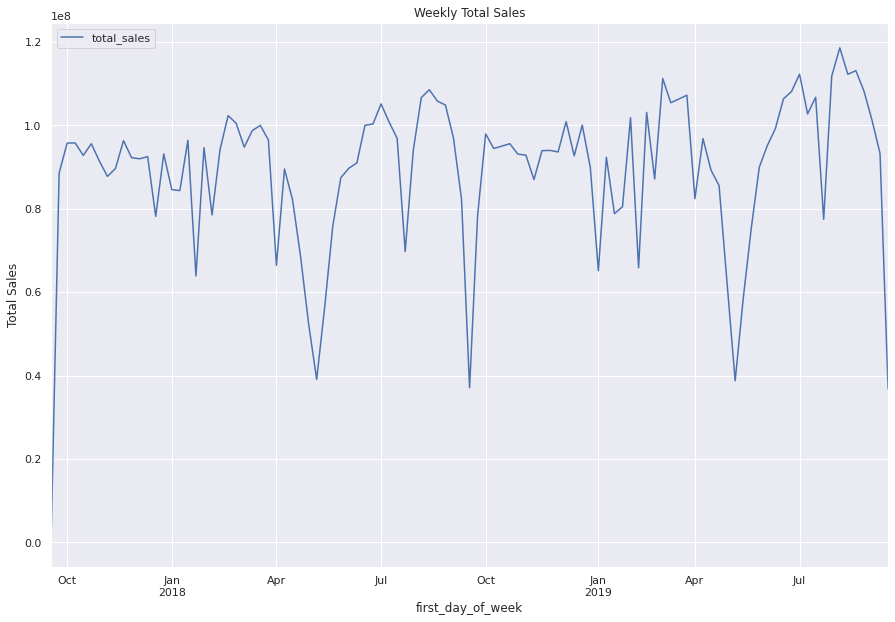

In [ ]:
weekly_df.plot(x="first_day_of_week", y="total_sales",kind='line',figsize=(15,10))
plt.ylabel('Total Sales')
plt.title('Weekly Total Sales')

### Weekly Sales by Customer Segment

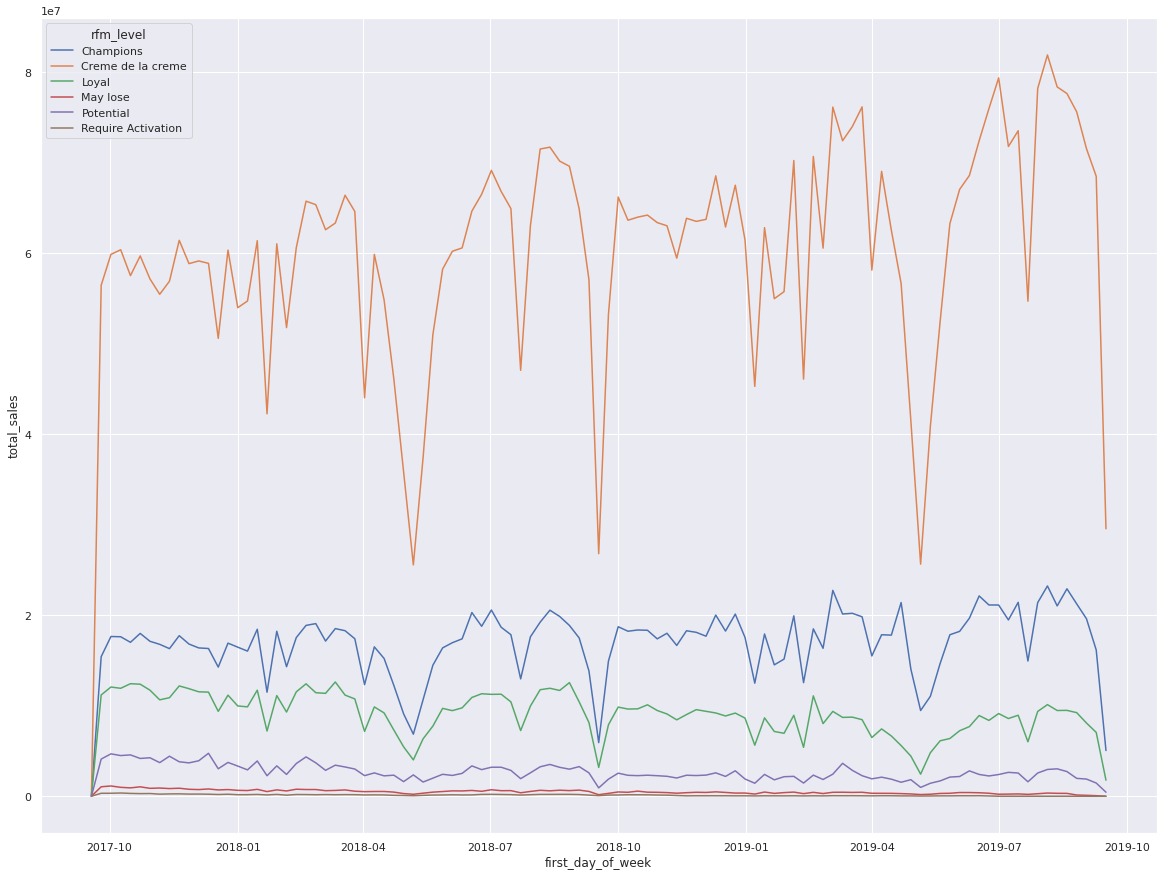

In [ ]:
sns.lineplot(data = weekly_df_segment, x = 'first_day_of_week', y = 'total_sales', hue = 'rfm_level')
sns.set(rc={'figure.figsize':(20,15)})
plt.show()

<a id='2'></a>
## 3. Forecasting Model

Now we will prepare the final dataframe in the format accepted by FB Prophet module:

In [ ]:
#define the columns as per format: ds for the date and y for the sales value
weekly_df.columns = ['ds', 'y']
weekly_df_segment.columns = ['ds', 'rfm_level','y']

In [ ]:
#We are going to test our model by considering the last 9 weeks (22nd July - 22nd Sep)
weekly_df.iloc[96:,:]

,ds,y
96,2019-07-22,"77,487,392.000"
97,2019-07-29,"111,843,120.000"
98,2019-08-05,"118,619,224.000"
99,2019-08-12,"112,272,160.000"
100,2019-08-19,"113,132,280.000"
101,2019-08-26,"108,256,480.000"
102,2019-09-02,"101,295,824.000"
103,2019-09-09,"93,269,648.000"
104,2019-09-16,"36,836,316.000"


<a id='3'></a>
## 3.1. Total Sales Prediction 

In [ ]:
#Train/Test split - we will split the data into train and test, where test set will be the last 9 weeks
data_train,data_test = weekly_df.iloc[:96,:].copy(),weekly_df.iloc[96:,:]
data_train.shape,data_test.shape

((96, 2), (9, 2))

Now we are going to define our model using Prophet module:
* As we are considering weekly sales, we are not going to consider daily seasonality
* Since our data is having weekly and yearly seasonality, we will consider both
* To give seasonality the required importance, we are going to scale it to 100

In [ ]:
#Define the model
model = prophet.Prophet(daily_seasonality = False,weekly_seasonality = True, yearly_seasonality = True,seasonality_prior_scale = 100)
#Fit the model using train set
model.fit(data_train)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/p55ly3iw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/3fkcx7e5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=989', 'data', 'file=/tmp/tmp0d24p3_l/p55ly3iw.json', 'init=/tmp/tmp0d24p3_l/3fkcx7e5.json', 'output', 'file=/tmp/tmp0d24p3_l/prophet_model2rzo8_rr/prophet_model-20230226131426.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:14:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:14:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
#Let's prepare our test set by resetting the index and removing the real values
data_test_forecast = (data_test.reset_index(drop = True)
                      .drop(["y"], axis =1))
data_test_forecast

,ds
0,2019-07-22
1,2019-07-29
2,2019-08-05
3,2019-08-12
4,2019-08-19
5,2019-08-26
6,2019-09-02
7,2019-09-09
8,2019-09-16


Now we use the trained model to predict the forecast of our test set:

          ds            yhat      yhat_lower      yhat_upper
0 2019-07-22  90,661,677.848  78,069,462.548 103,691,227.931
1 2019-07-29  89,022,229.723  74,509,257.807 100,579,824.931
2 2019-08-05  99,469,367.447  86,813,169.384 111,656,930.805
3 2019-08-12 115,502,274.040 102,396,585.601 128,599,661.240
4 2019-08-19 123,871,308.405 111,161,785.917 136,527,049.375


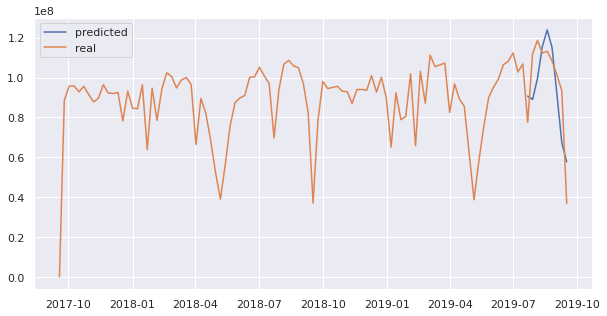

In [ ]:
forecast = model.predict(data_test_forecast)
# summarize the forecast
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

# plot forecasted against the real values
plt.figure(figsize = (10,5))
plt.plot(forecast['ds'],forecast['yhat'],label = 'predicted')
plt.plot(weekly_df['ds'],weekly_df['y'],label='real')
plt.legend()
plt.show()

Now we are going to evaluate the model performance by computing MAPE and MAE

In [ ]:
comparison_df = data_test.copy(deep=True)
# calculate MAE between expected and predicted values for december
comparison_df.columns = ['date', 'true_sales']
comparison_df['pred_sales'] = forecast['yhat'][forecast['ds'] <= '2019-09-22'].values
#y_true = data_test['y'].values
#y_pred = forecast['yhat'][forecast['ds'] <= '2019-09-22'].values
mape = mean_absolute_percentage_error(comparison_df['true_sales'].values, comparison_df['pred_sales'].values)
print('MAPE: %.3f' % mape)
mae = mean_absolute_error(comparison_df['true_sales'].values, comparison_df['pred_sales'].values)
print('MAE: %.3f' % mae)

MAPE: 0.185
MAE: 14742763.706


In [ ]:
comparison_df

,date,true_sales,pred_sales
96,2019-07-22,"77,487,392.000","90,661,677.848"
97,2019-07-29,"111,843,120.000","89,022,229.723"
98,2019-08-05,"118,619,224.000","99,469,367.447"
99,2019-08-12,"112,272,160.000","115,502,274.040"
100,2019-08-19,"113,132,280.000","123,871,308.405"
101,2019-08-26,"108,256,480.000","114,967,515.123"
102,2019-09-02,"101,295,824.000","91,407,472.999"
103,2019-09-09,"93,269,648.000","67,250,189.610"
104,2019-09-16,"36,836,316.000","57,788,169.716"


Now we are going to use the same model to forecast the next 9 weeks sales, this time using the entire dataset (including the last 9 weeks that we disregarded in the test phase of the model):

In [ ]:
model2 = prophet.Prophet(daily_seasonality = False,weekly_seasonality = True, yearly_seasonality = True,seasonality_prior_scale = 100)
#Fit the model
model2.fit(weekly_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/r3nyi5hz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/24cl74_h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68707', 'data', 'file=/tmp/tmp0d24p3_l/r3nyi5hz.json', 'init=/tmp/tmp0d24p3_l/24cl74_h.json', 'output', 'file=/tmp/tmp0d24p3_l/prophet_modelzp4tf1yq/prophet_model-20230226131441.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:14:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:14:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


For the prediction, we are going to create a new dataframe with the week dates of the next 9 weeks (22 Sep 2019 - 22 Nov 2019):

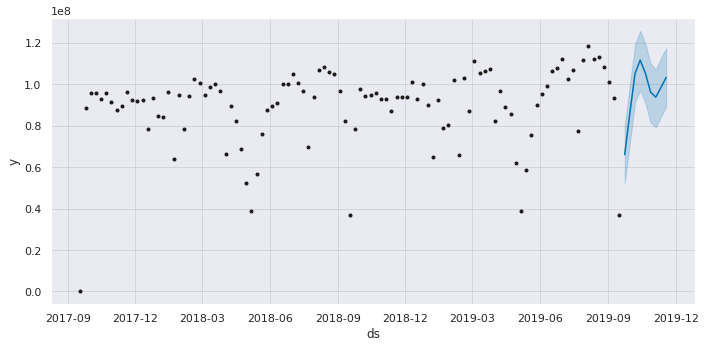

In [ ]:
# define the period for which we want a prediction
start_date = dt.date(2019, 9, 22)
end_date = dt.date(2019, 11, 22)
future = list()
for single_date in pd.date_range(start_date, end_date,freq='W-MON'):
    future.append([single_date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

# use the model to make a forecast
forecast_final = model2.predict(future)

#Plot the predicted results
model2.plot(forecast_final,figsize=(10,5))
plt.show()

Let us take a look at the total predicted sales, as well as the average weekly sales and some other statistics:

In [ ]:
forecast_final[["ds","yhat"]].sum()

yhat   866,240,119.006
dtype: float64

In [ ]:
forecast_final[["ds","yhat"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
yhat,9.000,"96,248,902.112","13,583,596.474","66,090,258.220","93,809,644.860","98,461,023.327","105,219,292.942","111,693,889.666"


<a id='4'></a>
## 3.2. Segment Level Sales Prediction 

We will first evaluate the model performance at segment level:

In [ ]:
# First, we create a list of all the segments
segments = weekly_df_segment.rfm_level.unique()

In [ ]:
# We define the period for which we want a prediction
start_date = dt.date(2019, 7, 22)
end_date = dt.date(2019, 9, 22)
future = list()
for single_date in pd.date_range(start_date, end_date,freq='W-MON'):
    future.append([single_date])

future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
forecast_final = pd.DataFrame() 

# We will loop through the segments one by one
for i in segments:
    print(i, " forecast:")
    # We will subset the dataframe vy the specific segment
    
    weekly_df_segment_selected = weekly_df_segment[weekly_df_segment["rfm_level"] == i].copy(deep = True)
    
    # Train test split 
    data_train,data_test = weekly_df_segment_selected.iloc[:96,:].copy(),weekly_df_segment_selected.iloc[96:,:]

    #Let us build the model and fit it on the train set
    model = prophet.Prophet(daily_seasonality = False,weekly_seasonality = True, yearly_seasonality = True,seasonality_prior_scale = 100)
    model.fit(data_train)

    # Now we predict the last 9 weeks
    forecast = model.predict(future)
    forecast["Segment"] = i
    
    # Let us append the values of each segment in a final dataframe
    forecast_final = forecast_final.append(forecast)
    comparison_df = data_test.copy(deep=True)
    
    # calculate MAPE and MAE between real and predicted values
    comparison_df.columns = ['date','Segment', 'true_sales']
    comparison_df['pred_sales'] = forecast_final['yhat'][(forecast_final['ds'] <= '2019-09-22') & (forecast_final['Segment'] == i)].values

    mape = mean_absolute_percentage_error(comparison_df['true_sales'].values, comparison_df['pred_sales'].values)
    print(i,": ",'MAPE: %.3f' % mape)
    mae = mean_absolute_error(comparison_df['true_sales'].values, comparison_df['pred_sales'].values)
    print(i,": ",'MAE: %.3f' % mae)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/2e2ewm8b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/_u3cd390.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23680', 'data', 'file=/tmp/tmp0d24p3_l/2e2ewm8b.json', 'init=/tmp/tmp0d24p3_l/_u3cd390.json', 'output', 'file=/tmp/tmp0d24p3_l/prophet_model21m_ql34/prophet_model-20230226132013.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:20:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Champions  forecast:


13:20:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/qn2ay8vu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/adz68j8q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6222', 'data', 'file=/tmp/tmp0d24p3_l/qn2ay8vu.json', 'init=/tmp/tmp0d24p3_l/adz68j8q.json', 'output', 'file=/tmp/tmp0d24p3_l/prophet_model_5li055o/prophet_model-20230226132014.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:20:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Champions :  MAPE: 0.244
Champions :  MAE: 2826797.088
Creme de la creme  forecast:


13:20:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/1pzj_22u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/al_8dbb6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37853', 'data', 'file=/tmp/tmp0d24p3_l/1pzj_22u.json', 'init=/tmp/tmp0d24p3_l/al_8dbb6.json', 'output', 'file=/tmp/tmp0d24p3_l/prophet_modelje8359q4/prophet_model-20230226132014.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:20:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Creme de la creme :  MAPE: 0.171
Creme de la creme :  MAE: 9946282.655
Loyal  forecast:


13:20:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/d1okmsfh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/o7nlqmoc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88816', 'data', 'file=/tmp/tmp0d24p3_l/d1okmsfh.json', 'init=/tmp/tmp0d24p3_l/o7nlqmoc.json', 'output', 'file=/tmp/tmp0d24p3_l/prophet_model0grjn347/prophet_model-20230226132015.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:20:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Loyal :  MAPE: 0.216
Loyal :  MAE: 1535980.050
May lose  forecast:


13:20:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/39_ezxrk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/jde6k5nj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88984', 'data', 'file=/tmp/tmp0d24p3_l/39_ezxrk.json', 'init=/tmp/tmp0d24p3_l/jde6k5nj.json', 'output', 'file=/tmp/tmp0d24p3_l/prophet_model5evpob59/prophet_model-20230226132015.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:20:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


May lose :  MAPE: 169.844
May lose :  MAE: 101521.164
Potential  forecast:


13:20:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/j9wv5il2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/v808d55l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61712', 'data', 'file=/tmp/tmp0d24p3_l/j9wv5il2.json', 'init=/tmp/tmp0d24p3_l/v808d55l.json', 'output', 'file=/tmp/tmp0d24p3_l/prophet_modelygv1jw2t/prophet_model-20230226132016.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:20:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Potential :  MAPE: 0.294
Potential :  MAE: 577239.941
Require Activation  forecast:


13:20:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Require Activation :  MAPE: 119397526418733580288.000
Require Activation :  MAE: 57284.045


Using the same model as for the total sales prediction, we are going to run a prediction for each segment:

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/7ojmzeh0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/8asjl4nq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67002', 'data', 'file=/tmp/tmp0d24p3_l/7ojmzeh0.json', 'init=/tmp/tmp0d24p3_l/8asjl4nq.json', 'output', 'file=/tmp/tmp0d24p3_l/prophet_modelmbc8fotf/prophet_model-20230226133134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:31:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:31:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Champions  forecast:


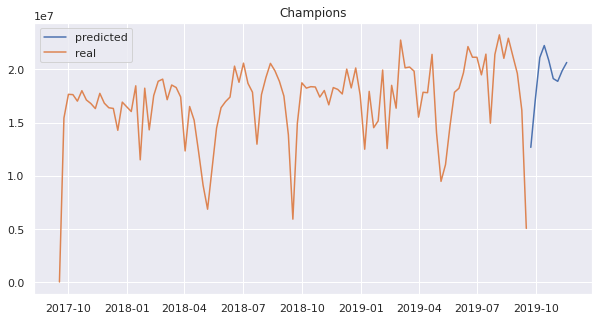

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/jmx85kbx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/ir93uczy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29540', 'data', 'file=/tmp/tmp0d24p3_l/jmx85kbx.json', 'init=/tmp/tmp0d24p3_l/ir93uczy.json', 'output', 'file=/tmp/tmp0d24p3_l/prophet_modelnf8nlea9/prophet_model-20230226133134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:31:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:31:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Creme de la creme  forecast:


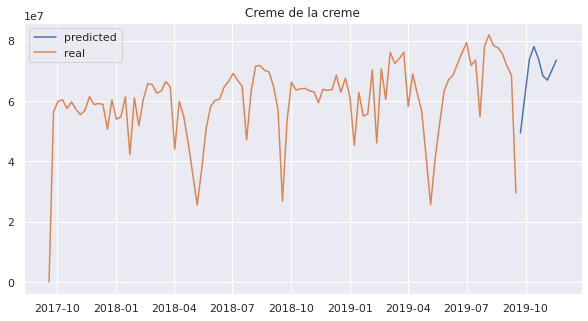

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/x4jc85x5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/8elhph2t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60929', 'data', 'file=/tmp/tmp0d24p3_l/x4jc85x5.json', 'init=/tmp/tmp0d24p3_l/8elhph2t.json', 'output', 'file=/tmp/tmp0d24p3_l/prophet_modelgdy0g__u/prophet_model-20230226133135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:31:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:31:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Loyal  forecast:


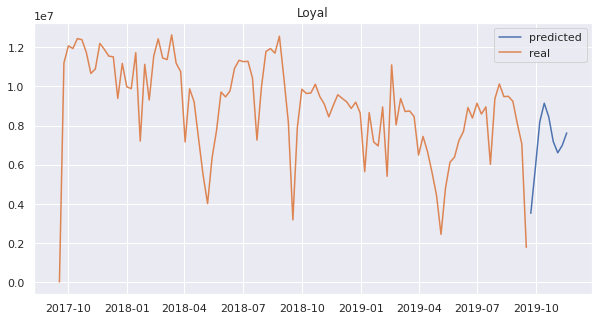

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/1x0orgya.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/n22b9q7k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52989', 'data', 'file=/tmp/tmp0d24p3_l/1x0orgya.json', 'init=/tmp/tmp0d24p3_l/n22b9q7k.json', 'output', 'file=/tmp/tmp0d24p3_l/prophet_modeldm2kn93d/prophet_model-20230226133135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:31:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:31:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


May lose  forecast:


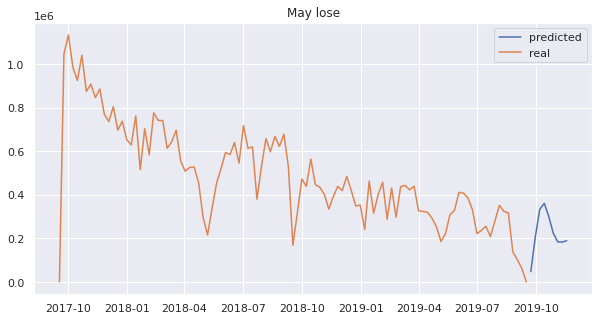

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/gmvi80q3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/259103n2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12335', 'data', 'file=/tmp/tmp0d24p3_l/gmvi80q3.json', 'init=/tmp/tmp0d24p3_l/259103n2.json', 'output', 'file=/tmp/tmp0d24p3_l/prophet_modelotfpwy0j/prophet_model-20230226133135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:31:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:31:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Potential  forecast:


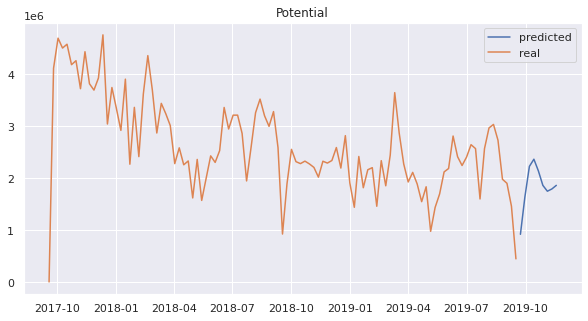

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/pdrhguw8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d24p3_l/iu9ni8ds.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98418', 'data', 'file=/tmp/tmp0d24p3_l/pdrhguw8.json', 'init=/tmp/tmp0d24p3_l/iu9ni8ds.json', 'output', 'file=/tmp/tmp0d24p3_l/prophet_modelclr4a_8p/prophet_model-20230226133136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:31:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:31:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Require Activation  forecast:


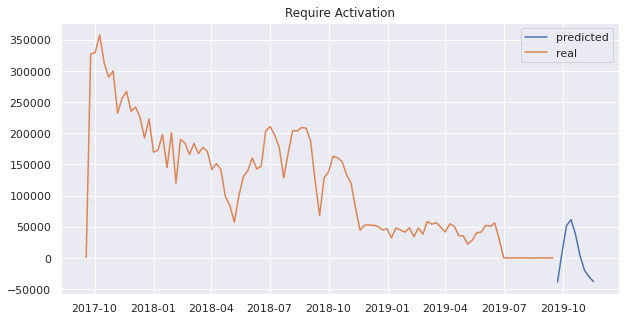

In [ ]:
# We define the future period for which we want a prediction (22 Sep - 2019 - 22 Nov 2019)
start_date = dt.date(2019, 9, 22)
end_date = dt.date(2019, 11, 22)
future = list()

for single_date in pd.date_range(start_date, end_date,freq='W-MON'):
    future.append([single_date])
    
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
forecast_final = pd.DataFrame() 

# We will loop through the segments and predict future sales 
for i in segments:
    print(i, " forecast:")
    weekly_df_segment_selected = weekly_df_segment[weekly_df_segment["rfm_level"] == i].copy(deep = True)
    model = prophet.Prophet(daily_seasonality = False,weekly_seasonality = True, yearly_seasonality = True,seasonality_prior_scale = 100)
    model.fit(weekly_df_segment_selected)
    forecast = model.predict(future)
    forecast["Segment"] = i
    forecast_final = forecast_final.append(forecast)
    
    #Plot the predicted results
    plt.figure(figsize = (10,5))
    plt.plot(forecast['ds'],forecast['yhat'],label = 'predicted')
    plt.plot(weekly_df_segment_selected['ds'],weekly_df_segment_selected['y'],label='real')
    plt.legend()
    plt.title(i)
    plt.show()

Let us take a look at the total predicted sales, as well as the average weekly sales and some other statistics by segments:

In [ ]:
total_forecast_final = forecast_final[["ds","yhat","Segment"]].groupby('Segment').sum()
total_forecast_final.columns = ["total_sales"]
total_forecast_final

,total_sales
Segment,
Champions,"172,557,480.535"
Creme de la creme,"616,139,003.917"
Loyal,"63,479,025.201"
May lose,"2,028,819.494"
Potential,"16,527,862.622"
Require Activation,"37,813.720"


In [ ]:
forecast_final_stat = forecast_final[["ds","yhat","Segment"]].groupby('Segment').describe().unstack(1).reset_index()

In [ ]:
forecast_final_stat = forecast_final_stat.T
new_header = forecast_final_stat.iloc[2] #grab the first row for the header
forecast_final_stat.columns = new_header #set the header row as the df header
forecast_final_stat = forecast_final_stat.drop('Segment')
forecast_final_stat

Segment,Champions,Creme de la creme,Loyal,May lose,Potential,Require Activation,Champions,Creme de la creme,Loyal,May lose,Potential,Require Activation,Champions,Creme de la creme,Loyal,May lose,Potential,Require Activation,Champions,Creme de la creme,Loyal,May lose,Potential,Require Activation,Champions,Creme de la creme,Loyal,May lose,Potential,Require Activation,Champions,Creme de la creme,Loyal,May lose,Potential,Require Activation,Champions,Creme de la creme,Loyal,May lose,Potential,Require Activation,Champions,Creme de la creme,Loyal,May lose,Potential,Require Activation
level_0,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat,yhat
level_1,count,count,count,count,count,count,mean,mean,mean,mean,mean,mean,std,std,std,std,std,std,min,min,min,min,min,min,25%,25%,25%,25%,25%,25%,50%,50%,50%,50%,50%,50%,75%,75%,75%,75%,75%,75%,max,max,max,max,max,max
0,9.000,9.000,9.000,9.000,9.000,9.000,"19,173,053.393","68,459,889.324","7,053,225.022","225,424.388","1,836,429.180","4,201.524","2,851,969.823","8,581,742.952","1,665,294.955","95,377.565","419,404.178","38,835.961","12,672,023.193","49,461,044.353","3,517,101.007","47,122.500","918,385.109","-38,533.404","18,878,249.194","66,929,575.972","6,608,080.954","184,061.580","1,746,032.652","-30,307.422","19,880,456.958","70,180,692.822","7,184,360.197","205,963.910","1,857,979.344","3,964.792","20,847,804.828","73,805,973.640","8,188,451.815","300,867.142","2,135,839.458","38,006.823","22,240,657.741","78,023,979.767","9,139,162.533","360,703.657","2,360,521.921","61,498.982"
